In [21]:
import sys
import psycopg2
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn import preprocessing

from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import my_pass
%matplotlib inline 

In [22]:
def reading(host, DB, username, password):
    conn_string = "host=" + host + " dbname=" + DB + " user=" + username + " password=" + password
    # get connected to the database
    connection = psycopg2.connect(conn_string)
    query = "SELECT * FROM b2w_schema.sales_agg;"
    sales = psql.read_sql(query, connection)
    # Here I'm only selecting immeadiate pay
    query = "SELECT prod_id,date_order,competitor, min(competitor_price) as competitor_price \
    FROM b2w_schema.comp_prices  \
    GROUP BY prod_id,date_order,competitor,pay_type \
    HAVING pay_type = 2;"
    price_im = psql.read_sql(query, connection)
    return (sales,price_im)


class ml_models(object):

    def __init__(self, data, product, name):
        self.df = data
        self.product = product
        self.name = name

    def qty_lag(self):
        self.df.sort(['date_order'], ascending=[1], inplace = True)
        self.df['qty_lag_1'] = self.df['qty_order'].shift(1)
        self.df.loc[0,('qty_lag_1')] = self.df.loc[1,('qty_lag_1')]
        
    def prepare_data(self):
        # selecting a specific product to analyse
        self.df = self.df[self.df['prod_id'] == self.product]

        # Remove columns that only have missing values
        self.df = self.df.dropna(axis=1,how='all')

        # Transforming categorical varibales into factors
        le_day_week = preprocessing.LabelEncoder()
        self.df['day_week'] = le_day_week.fit_transform(self.df['day_week'])
        self.df['month'] = le_day_week.fit_transform(self.df['month'])
        
        # Creating a lag1 of quantity sold
        self.qty_lag()

    def rem_rows_comp_NA(self, cols):
        na_rows = self.df[cols].isnull().sum(axis=1)
        self.df = self.df.ix[na_rows != len(cols)]
        
    def fill_comp_price_NA(self, competitors):
        for comp in competitors:
            df = self.df[competitors]
            df.drop(comp, axis=1, inplace=True)
            self.df.loc[:,('aux_col')] = df.mean(axis=1, skipna = True)
            null_rows = self.df.loc[:,(comp)].isnull()
            self.df.loc[null_rows,(comp)] = self.df.loc[null_rows,('aux_col')]
            self.df.drop('aux_col', axis=1, inplace=True)
    
    def fill_prod_price_NA(self,col):
        min_value = df[col].min(axis = 0, skipna = True)
        null_rows = self.df.loc[:,(col)].isnull()
        self.df.loc[null_rows,(col)] = min_value
        
    
    def make_train_test(self,frac = 0.8, random_state = 200):
        # creating a training and test sets
        self.df_train = self.df.sample(frac = frac, random_state = random_state)
        self.df_test = self.df.drop(self.df_train.index)
        
    def select_X_Y(self,Y, X_keep = [], X_drop = []):
        
        # Isolate Response variable
        self.Y_train, self.Y_test = self.df_train[Y], self.df_test[Y]

        # warning: drop_feat overrides keep_feat !!!
        if X_drop:
            self.X_train = self.df_train.drop(X_drop, axis=1, inplace=False)
            self.X_test = self.df_test.drop(X_drop, axis=1, inplace=False)
            # Remove Response variable from regressor set
            self.X_train.drop(Y, axis=1, inplace=True)
            self.X_test.drop(Y, axis=1, inplace=True)
        elif X_keep:
            self.X_train = self.df_train[X_keep]
            self.X_test = self.df_test[X_keep]

        # Total number of regressors
        self.n_regressors = len(self.X_test.columns)

    def predict_test(self, print_results = True):
        # Predict and update dataset
        self.Y_pred = self.clf.predict(self.X_test)
        self.mse = metrics.mean_squared_error(self.Y_test, self.Y_pred)
        self.mae = metrics.mean_absolute_error(self.Y_test, self.Y_pred)

    def print_metrics(self, regression_metrics = True):
        print 'Model: ', self.name
        if regression_metrics:
            print "MAE: %.4f" % self.mae
            print "MSE: %.4f" % self.mse

    def merge_result(self):
        d = {'Y_test': self.Y_test, 'Y_pred': self.Y_pred}
        df = pd.DataFrame(data=d)
        self.df_test = pd.merge(self.df_test, df, how='left', left_index = True, right_index = True)

    def write_model_results(self, output_path):
        # Writing the results to output folder
        self.df_test.to_csv(output_path + self.product + '_' + self.name  + '.csv',index = False)

class GBM(ml_models):
    # Gradient Boosting Regression
    def __init__(self, data, product):
        ml_models.__init__(self, data, product, name = "GBR")

    def grid_search(self, params):
        # Finding best parameters
        gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, \
            min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',\
            subsample=0.8,random_state=5), param_grid = params, n_jobs=4,iid=False, cv=5)
        gsearch.fit(self.X_train, self.Y_train)
        self.grid_scores, self.best_params = gsearch.grid_scores_, gsearch.best_params_

    def fit_gb(self, params):
        # Fit model
        self.clf = GradientBoostingRegressor(**params)
        self.clf.fit(self.X_train, self.Y_train)

    def plot_feature_importance(self, n):
        importances = self.clf.feature_importances_
        feature_names = self.X_test.columns
        indices = np.argsort(importances)[::-1][:n]
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10,6)
        plt.title("Feature importances", fontsize = 16)
        xlabels = [feature_names[int(i)] for i in indices]
        plt.bar(range(n), importances[indices],
                color="#799DBB",  align="center")
        plt.grid()
        plt.xticks(range(n), xlabels, rotation=90)
        plt.xlim([-1, n])
        plt.ylim([0, min(1, max(importances[indices]+0.0005))])
        plt.xlabel('Features', fontsize = 14)
        plt.ylabel('Feature Importance', fontsize = 14)
        plt.title('Product '+  self.product +' Variable Importance')
        plt.show()


class MLR(ml_models):
    # Multiple linear regression
    def __init__(self, data, product):
        ml_models.__init__(self, data, product, name = "MLR")

    def fit_mlr(self):
        # Fit model
        self.clf = linear_model.LinearRegression(fit_intercept=False)
        self.clf.fit(self.X_train, self.Y_train)
        self.clf.coef = self.clf.coef_

# Analysis

#### Fixed Inputs

In [23]:
# Product List
all_products = ['P1','P2','P3','P4','P5','P6','P7','P8','P9']

# Output Path
output_path = '/Users/felipeformentiferreira/Documents/github_portfolio/pricing_challenge/data/output/'

# Database inputs
host = 'localhost'
DB = 'postgres'
username = my_pass.username
password = my_pass.password

### Reading Data

In [24]:
# Reading tables
sales, price_im = reading(host, DB, username, password)

### Getting the Competitor's Price

In [25]:
# Reshaping the data to perform a join in order to get Competitor's Prices
price_im_wide = pd.pivot_table(price_im, index = ['prod_id','date_order'], \
    columns = ['competitor'], values = 'competitor_price')
price_im_wide.reset_index(inplace = True)
master_df = pd.merge(sales, price_im_wide, how='left', on=['prod_id','date_order'])

### Getting other Product's Price

In [6]:
# # Reshaping the data to perform a join in order to get the Product's Prices
# day_price_prod = master_df[['prod_id','date_order','price']]
# day_price_prod_wide = pd.pivot_table(day_price_prod, index = ['date_order'], \
#     columns = ['prod_id'], values = 'price')
# day_price_prod_wide.reset_index(inplace = True)
# master_df = pd.merge(master_df, day_price_prod_wide, how='left', on=['date_order'])

## Fitting Models

### P1

In [13]:
my_product = 'P1'
competitors = ['C1','C2','C3','C5','C6']

#### Linear Regression (Baseline)

In [14]:
# Creating a Gradient Boosting Object with the dataframe and a given product
mlr = MLR(master_df, my_product)
mlr.prepare_data()

# Removing rows where there is no price for any competitor
mlr.rem_rows_comp_NA(competitors)

# Creating a training and a test set to evaluate model later
mlr.make_train_test()
mlr.select_X_Y(Y = 'qty_order', X_keep = ['price'])

# Fitting model with best parameters
mlr.fit_mlr()

# Predict
mlr.predict_test()
mlr.print_metrics(regression_metrics = True)

# Writing results
mlr.merge_result()
mlr.write_model_results(output_path)
print "Price coef: ", mlr.clf.coef[0]

Model:  MLR
MAE: 7.7900
MSE: 104.3331
Price coef:  0.0109616830531


In [15]:
mlr.df_test[['prod_id','date_order','price','Y_test','Y_pred']].head(10)

,prod_id,date_order,price,Y_test,Y_pred
987,P1,2015-03-16,1402.312500,24,15.371705
103,P1,2015-03-22,1421.000000,7,15.576552
1896,P1,2015-03-29,1499.000000,7,16.431563
927,P1,2015-03-31,1483.776364,11,16.264686
1652,P1,2015-04-04,1480.262500,8,16.226168
1031,P1,2015-04-07,1487.461538,13,16.305082
910,P1,2015-04-10,1457.333333,12,15.974826
291,P1,2015-04-19,1389.007143,14,15.225856
246,P1,2015-04-26,1399.000000,13,15.335395
716,P1,2015-05-05,1440.670000,30,15.792168


#### Gradient Boosting

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model:  GBR
MAE: 5.6732
MSE: 49.9864


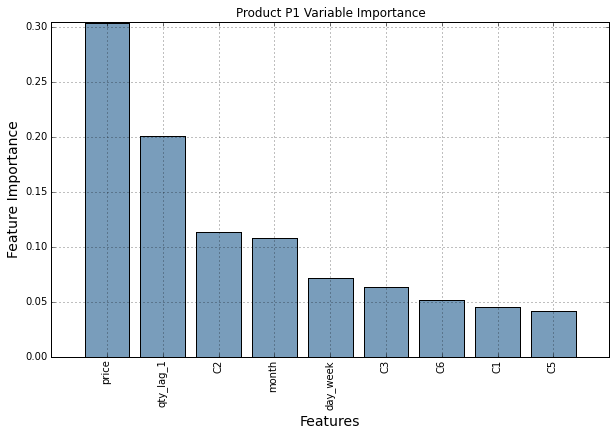

In [16]:
# Creating a Gradient Boosting Object with the dataframe and a given product
gb = GBM(master_df, my_product) 
gb.prepare_data()

# Removing rows where there is no price for any competitor
gb.rem_rows_comp_NA(competitors)

# Fill missing values for competitors price
gb.fill_comp_price_NA(competitors)

# Creating a training and a test set to evaluate model later
gb.make_train_test()
gb.select_X_Y(Y = 'qty_order', X_drop = ['prod_id','revenue','date_order'])

# Grid Search to find best parameters
params = {'n_estimators': [50, 100, 300, 500], 'max_depth': [2,3,4], 'max_features': ['sqrt']}
gb.grid_search(params)

# Fitting model with best parameters
gb.fit_gb(gb.best_params)

# Predict
gb.predict_test()
gb.print_metrics(regression_metrics = True)

# Writing results
gb.merge_result()
gb.write_model_results(output_path)

# Plot feature importance
gb.plot_feature_importance(gb.n_regressors)

In [17]:
# Printing grid search
gb.grid_scores

[mean: -0.03770, std: 0.03630, params: {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 2},
 mean: -0.00899, std: 0.00959, params: {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 2},
 mean: -0.02324, std: 0.02946, params: {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 2},
 mean: -0.02200, std: 0.02547, params: {'max_features': 'sqrt', 'n_estimators': 500, 'max_depth': 2},
 mean: -0.02141, std: 0.02599, params: {'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 3},
 mean: -0.02528, std: 0.03374, params: {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3},
 mean: -0.02324, std: 0.02946, params: {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 3},
 mean: -0.02200, std: 0.02547, params: {'max_features': 'sqrt', 'n_estimators': 500, 'max_depth': 3},
 mean: -0.02141, std: 0.02599, params: {'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 4},
 mean: -0.02528, std: 0.03374, params: {'max_features': 'sqrt', 'n_estimators': 100,

In [18]:
gb.df_test[['prod_id','date_order','price','Y_test','Y_pred']].head(10)

,prod_id,date_order,price,Y_test,Y_pred
987,P1,2015-03-16,1402.312500,24,26.999431
103,P1,2015-03-22,1421.000000,7,16.499028
1896,P1,2015-03-29,1499.000000,7,13.615307
927,P1,2015-03-31,1483.776364,11,12.187607
1652,P1,2015-04-04,1480.262500,8,7.095488
1031,P1,2015-04-07,1487.461538,13,6.365761
910,P1,2015-04-10,1457.333333,12,11.155337
291,P1,2015-04-19,1389.007143,14,3.834154
246,P1,2015-04-26,1399.000000,13,9.478059
716,P1,2015-05-05,1440.670000,30,19.713369
